# Evaluation
This code contains all the necessary code to perform the necessary evaluations of the individual parts.

In [1]:
file_output_exercise1 = "../output.txt"
file_output_exercise2_rdd = "../output_rdd.txt"
file_output_exercise2_ds = "../output_ds.txt"
file_grid_search_evaluation = "../grid_search_evaluation.csv"

## Load results

This function is utilized to read and parse the output files of the designated exercises, as the categories, tokens, and chi-square values are embedded in a specific format.

In [2]:
def parse_file(file_path):
    category_terms = {}
    with open(file_path, 'r') as file:
        lines = file.readlines()    

    merged_dict = None

    for line in lines:
        if line.startswith('<'):
            line_splitted = line.split(' ')
            category = line_splitted[0].replace('<', '').replace('>', '')
            terms = line_splitted[1:]
            for term_chisquared in terms:
                term, chi_squared = term_chisquared.split(':', 2)
                if category not in category_terms:
                    category_terms[category] = {}

                category_terms[category][term] = float(chi_squared)
        else:

            merged_dict = line.split(' ')
                
       
    return category_terms, merged_dict

In [3]:
chi_squared_ex1, merged_dict_ex1 = parse_file(file_output_exercise1)
chi_squared_ex2_rdd, merged_dict_ex2_rdd = parse_file(file_output_exercise2_rdd)
_, merged_dict_ex2_ds = parse_file(file_output_exercise2_ds)

## Part 1

In this part, we want to compare the results that we obtained in Exercise 1 using the generic MapReduce approach with the results we received when implementing the chi-square calculation using RDDs.

This function checks if a token from the MapReduce approach exists in the RDD and vice versa. If they both exist, their chi-square value difference is computed, and if missing, they are tracked as missing terms.

In [4]:
from collections import defaultdict

def compareResults(chi_squared1, chi_squared2):
    result = {}
    missing_categories = defaultdict(list)
    for category in chi_squared1:
        result[category] = {}

        for term in chi_squared1[category]:
            result[category][term] = True
            if term in chi_squared2[category]:
                result[category][term] &= abs(chi_squared1[category][term] - chi_squared2[category][term]) < 0.001
            else:
                result[category][term] &= False
                missing_categories[category].append(((term, chi_squared1[category][term]), 'mapreduce'))

    for category in chi_squared2:
        for term in chi_squared2[category]:
            if term not in chi_squared1[category]:
                result[category][term] = False
                missing_categories[category].append(((term, chi_squared2[category][term]), 'rdd'))

    return result, missing_categories


In [5]:
result, missing_categories = compareResults(chi_squared_ex1, chi_squared_ex2_rdd)

In [6]:
def print_results(result):
    cnt = 0
    for category, term_difference in result.items():
        for term, is_different in term_difference.items():
            if is_different == False:
                cnt += 1
                print(f"Category: {category} Term: {term}")

    print(f"Total of different terms: {cnt}")

print_results(result)

Category: Apps_for_Android Term: devs
Category: Apps_for_Android Term: glu
Category: Apps_for_Android Term: teamlava
Category: Apps_for_Android Term: zynga
Category: Tools_and_Home_Improvement Term: bidet
Category: Tools_and_Home_Improvement Term: kidde
Total of different terms: 6


In [7]:
missing_categories

defaultdict(list,
            {'Apps_for_Android': [(('devs', 86.64962060177764), 'mapreduce'),
              (('glu', 86.64962060177764), 'mapreduce'),
              (('teamlava', 86.64962060177764), 'rdd'),
              (('zynga', 86.64962060177764), 'rdd')],
             'Tools_and_Home_Improvement': [(('bidet', 159.72357729489363),
               'mapreduce'),
              (('kidde', 159.72357729489363), 'rdd')]})

Finally, we observe that in the category 'Apps_for_Android,' two words are missing in the MapReduce dataset but have the same chi-square values, while on the other side, two words in the same category are missing in the RDD dataset. For the category 'Tools_and_Home_Improvement,' a word is missing in one dataset that the other dataset has, and vice versa. Surprisingly, both of these words have the same chi-square values but appear to be totally different.

## Part 2

In this section, we compare the results obtained in Exercise 2, Part 1, where we selected the top 75 tokens based on their chi-squared value, with the features selected by the ChiSqSelector. We aim to determine how many tokens from the top 75k RDD dataset are included in the dataset assigned by the ChiSqSelector.

In [8]:
len(merged_dict_ex2_rdd), len(merged_dict_ex2_ds), len(set(merged_dict_ex2_rdd) & set(merged_dict_ex2_ds))

(1464, 2000, 750)

The results show that the intersection of both datasets consists of 750 words.

## Part 3

In this section, we aim to investigate the parameters of the grid search and their F1 scores on the validation set. To accomplish this, we load a CSV file consisting of all relevant information, inspect the results in a table, and create meaningful plots that may help to understand the parameters and their behavior more effectively.


First, import the data and convert the parameters into strings so that they are recognized as categorical variables on the x-axis.

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv(file_grid_search_evaluation)
df.columns = df.columns.str.strip() 

df["maxIter"] = df["maxIter"].astype(str)
df["NumTopFeatures"] = df["NumTopFeatures"].astype(str)
df["regParam"] = df["regParam"].astype(str)
df["standardization"] = df["standardization"].astype(str)

Inspect the parameters

In [10]:
df

,maxIter,NumTopFeatures,regParam,standardization,f1-score
0,10,20,0.001,False,0.244530
1,50,20,0.001,False,0.253933
2,10,20,0.001,True,0.247545
3,50,20,0.001,True,0.239803
4,10,2000,0.001,False,0.399768
5,50,2000,0.001,False,0.451065
6,10,2000,0.001,True,0.430844
7,50,2000,0.001,True,0.422536
8,10,20,0.01,False,0.230873
9,50,20,0.01,False,0.255260


Build a plot to gain a more intuitive understanding of which models perform best and worst.

[Text(0.5, 0, 'Model'), Text(0, 0.5, 'F1-Score')]

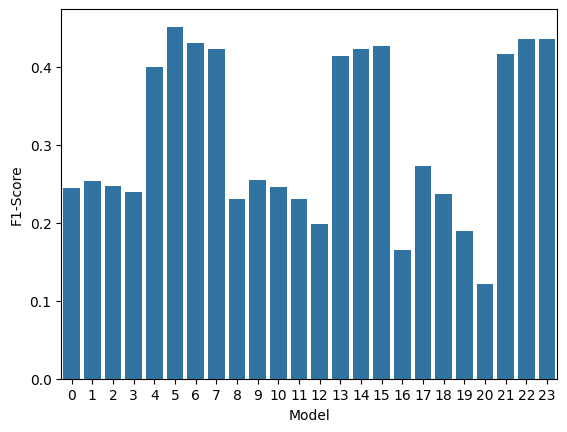

In [11]:
ax = sns.barplot(df, x=df.index, y="f1-score", fill="f1-score")
ax.set(xlabel="Model",ylabel="F1-Score")

It seems that every 4 to 5 models, the F1 scores rapidly increase. It is worth taking a closer look at those models that have an F1 score larger than 0.30.

In [12]:
df[df["f1-score"] > .3]

,maxIter,NumTopFeatures,regParam,standardization,f1-score
4,10,2000,0.001,False,0.399768
5,50,2000,0.001,False,0.451065
6,10,2000,0.001,True,0.430844
7,50,2000,0.001,True,0.422536
13,50,2000,0.01,False,0.413916
14,10,2000,0.01,True,0.422287
15,50,2000,0.01,True,0.426214
21,50,2000,0.1,False,0.415682
22,10,2000,0.1,True,0.435021
23,50,2000,0.1,True,0.435813


The filtering shows that indeed, models with 2000 selected features by the chi-square selector parameter value have significantly better model performance. We want to validate this. A plot consisting of 4 subplots is created to observe the parameters against the performance metric. Hence, we apply a color mapping to see if perhaps parameters that are part of a model that performs well also have their NumTopFeatures set to 2000.

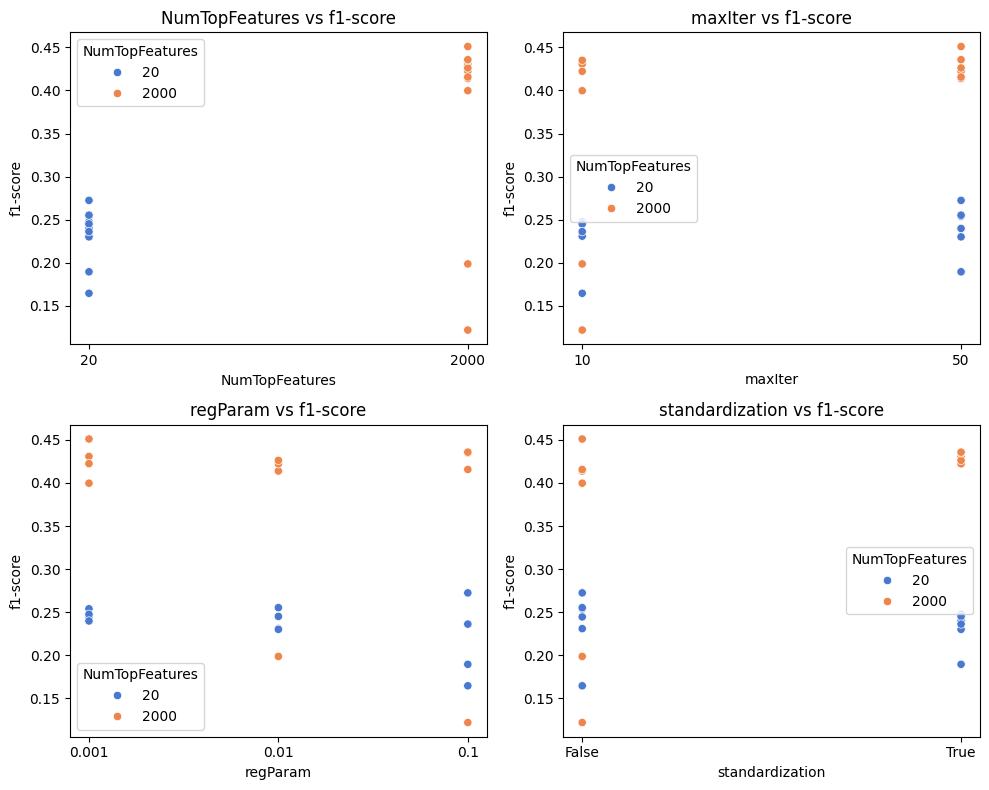

In [13]:
palette_name = "muted"
columns = ['NumTopFeatures', 'maxIter', 'regParam', 'standardization']
titles = ['NumTopFeatures vs f1-score', 'maxIter vs f1-score', 'regParam vs f1-score', 'standardization vs f1-score']


fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for i, col in enumerate(columns):
    row_index = i // 2
    col_index = i % 2
    
    sns.scatterplot(data=df, x=col, y='f1-score', hue='NumTopFeatures', palette=palette_name, ax=axs[row_index, col_index])
    
    axs[row_index, col_index].set_title(titles[i])
    axs[row_index, col_index].set_xlabel(col)
    axs[row_index, col_index].set_ylabel('f1-score')

plt.tight_layout()
plt.show()


Indeed, most of the models with the numTopFeatures set to 2000 achieve relatively high performance regardless of the parameter settings for regParam, standardization, and maxIter.